In [1]:
import os
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
import numpy as np
from utils.utils import DataProcessor, ConfigJSON, Logger
import utils.utils as utils
import utils.jax_utils as jax_utils
from trainer_jax import Trainer
import flax.training.train_state as flax_TrainState
import jax
import optax
from flax import linen as nn
from jax import random
import jax.numpy as jnp
from functools import partial
import distrax


CUDANUM = 0
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = str(CUDANUM)


from models.nsf import NeuralSplineFlow

In [11]:
EXP_NAME = '23_jax_snf_f5_v18_t02_4layer_moresteer2'
CONTINUE_TRAINING = 0

class Config(ConfigJSON):
    exp_name = EXP_NAME
    savedir = '/home/lucerna/MEGA/Reasearch/tuner_inn/tuner_inn/results/' + EXP_NAME + '/'
    # datadir = '/media/lucerna/DATA/tuner_inn/fric3_rand_acc4_t02/'
    datadir = '/home/lucerna/Documents/DATA/tuner_inn/track39/'
    test_datadir = '/home/lucerna/Documents/DATA/tuner_inn/fric3_rand_test/'
    train_segment = 2
    latent_size = 1
    pe_level = 3
    batchsize = 2000
    lr = 5e-4
    test_period = 10
    n_dim = 3 * 1 * 2
    n_context = 6 * 3 * 2
    n_sample = 100
    pre_mode = False
    
    hidden_dims = [128, 128]
    n_transforms = 4
    n_bins = 3
    
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = str(CUDANUM)

config = Config()

In [12]:
data = np.load(config.datadir + 'train_data_f5.npz')
test_states = np.asarray(data['train_states'])[0, :, 0, :]
test_controls = np.asarray(data['train_controls'])[0, :, 1, :]
test_dynamics = np.asarray(data['train_dynamics'])[0, :, 0, :]
print('test_states', test_states.shape)

pe = jax_utils.PositionalEncoding_jax(3)
pe1 = jax_utils.PositionalEncoding_jax(1)
c = ConfigJSON()
dp = DataProcessor()
c.load_file(config.savedir + 'config.json')
normalization_param = np.array(c.d['normalization_param']).T
dyna_normalization_param = normalization_param[:, 4:7]

# test_states = dp.de_normalize(test_states, normalization_param[:, 0:4])
# test_controls = dp.de_normalize(test_controls, normalization_param[:, 7:9])
# test_dynamics = dp.de_normalize(test_dynamics, normalization_param[:, 4:7])

test_states = dp.runtime_normalize(test_states, normalization_param[:, 0:4])
test_controls = dp.runtime_normalize(test_controls, normalization_param[:, 7:9])
test_dynamics = dp.runtime_normalize(test_dynamics, normalization_param[:, 4:7])

test_data = jnp.concatenate([test_states, test_controls, test_dynamics], axis=1)
test_context = pe.batch_encode(test_data[:, :6])
test_dyna = pe1.batch_encode(test_data[:, 6:9])
print(test_context.shape)
print(test_dyna.shape)

test_states (37232, 4)
(37232, 36)
(37232, 6)


In [13]:
jrng = jax_utils.oneLineJaxRNG(0)
test_perms = jax_utils.generate_perms(jrng.new_key(), test_states.shape[0], config.batchsize)
model = NeuralSplineFlow(n_dim=config.n_dim, n_context=config.n_context, 
                                hidden_dims=config.hidden_dims, 
                                n_transforms=config.n_transforms, activation="relu", 
                                n_bins=config.n_bins)

x_init = jnp.zeros((config.batchsize, config.n_dim))
x_context = jnp.zeros((config.batchsize, config.n_context))
dist = distrax.MultivariateNormalDiag(jnp.zeros(6), jnp.ones(6)/5)

print(x_init.shape, x_context.shape)
params = model.init(jrng.new_key(), x_init, x_context)
def model_merit_fn(info):
    return info[1]


(2000, 6) (2000, 36)


In [14]:
flax_train_state = flax_TrainState.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optax.chain(optax.clip_by_global_norm(8), 
                       optax.adam(learning_rate=config.lr)),
    )


@jax.jit
def test_step(state, rng_key, context):
    context_batch = context[None, :, :].repeat(config.n_sample, 0).reshape(-1, context.shape[-1])
    z = dist.sample(seed=rng_key, sample_shape=(context_batch.shape[0],))
    samples = model.apply(state.params, z, context_batch, method=model.sample)
    samples = pe.batch_decode2(samples)
    samples = samples.reshape(config.n_sample, -1, samples.shape[-1])
    samples_mean = samples.mean(axis=0)
    return samples_mean, samples

epoch_info = np.zeros(5)
trainer = Trainer(EXP_NAME, config.savedir,
                    max_epoch=500, best_fn=model_merit_fn,
                    info_template=epoch_info, initial_lr=config.lr)
# path = '/home/lucerna/Documents/DATA/results/23_0_jax_maf/23_0_jax_maf_model_best'
flax_train_state, epoch_info = trainer.load_state(flax_train_state, epoch_info, save_name='last')
print(epoch_info)
# params = flax_train_state.params
np.set_printoptions(suppress=True, precision=10)

Load from model:  /home/lucerna/MEGA/Reasearch/tuner_inn/tuner_inn/results/23_jax_snf_f5_v18_t02_4layer_moresteer2/23_jax_snf_f5_v18_t02_4layer_moresteer2_model_last
[3000.            -37.308199046     0.0437317854    0.0639790073
    0.126660423     0.              0.              0.          ]


In [15]:
test_perms = jax_utils.generate_perms(jrng.new_key(), test_states.shape[0], config.batchsize)
for perm in test_perms:
    perm = perm[:400]
    break
# params = flax_train_state.params
# print(train_dynamics[ind])
config.n_sample = 10
ind = np.random.randint(0, perm.shape[0])
# dist = distrax.MultivariateNormalDiag(jnp.zeros(6), jnp.ones(6))
samples_mean, samples = test_step(flax_train_state, jrng.new_key(), test_context[perm, :])
denormalized_samples = dp.de_normalize(samples_mean, dyna_normalization_param)
# print(samples_mean - test_dynamics[perm, :])
denormalized_train_dyna = dp.de_normalize(test_dynamics[perm], dyna_normalization_param)
error = jnp.abs(denormalized_samples - denormalized_train_dyna).mean(axis=0)
# error = jnp.abs(samples_mean - test_dynamics[perm]).mean(axis=0)
print(error)
# context_batch = test_context[perm, :][None, :, :].repeat(n_sample, 0).reshape(-1, test_context.shape[-1])
# z = dist.sample(seed=jrng.new_key(), sample_shape=(context_batch.shape[0],))
# samples = model.apply(params, z, context_batch, method=model.sample)
# samples = pe.batch_decode2(samples)
# samples = samples.reshape(n_sample, -1, samples.shape[-1])
# samples_mean = samples.mean(axis=0)

[0.012773251 0.066453435 0.05304775 ]


0.053287655
-0.0042929947
0.053287655


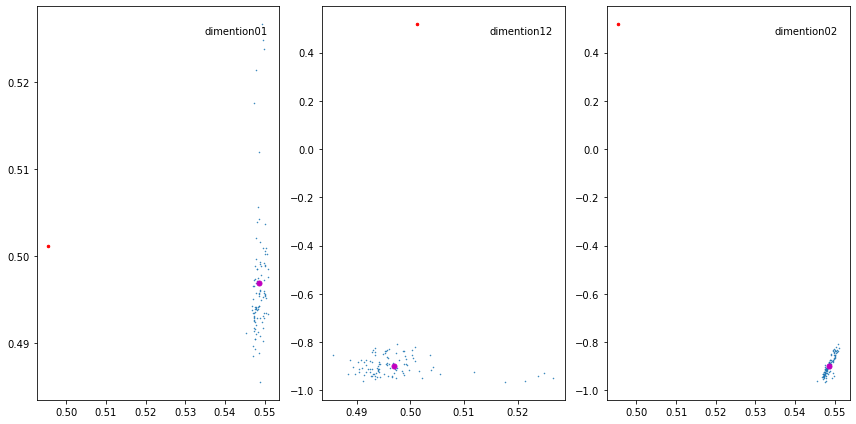

In [19]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(1, 3)
inds = np.array([[0, 1], [1, 2], [0, 2]], dtype=int)
ind = np.random.randint(0, perm.shape[0])
for ind2 in range(3):
    print(samples_mean[ind, inds[ind2, 0]] - test_dynamics[perm[ind], inds[ind2, 0]])
    ax = fig.add_subplot(gs[ind2])
    ax.plot(samples[:, ind, inds[ind2, 0]], samples[:, ind, inds[ind2, 1]], '.', markersize=1)
    ax.plot(samples_mean[ind, inds[ind2, 0]], samples_mean[ind, inds[ind2, 1]], '.m', markersize=10)
    ax.plot(test_dynamics[perm[ind], inds[ind2, 0]], test_dynamics[perm[ind], inds[ind2, 1]], '.r', markersize=5)
    # Add text to the upper right
    ax.text(0.95, 0.95, "dimention" + str(inds[ind2, 0]) + str(inds[ind2, 1]),
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes, color='black')
    
    # Set x and y limits
    # ax.set_xlim(0 ,1)
    # ax.set_ylim(0, 1)

    # Turn off the tick labels
    # ax.set_xticks([])
    # ax.set_yticks([])

plt.tight_layout()
